# Lecture 5: Advanced Forecasting Methods (MLP, Gradient Boosting, Kalman, LSTM)

In this lecture, you will continue exploring various approaches for **multivariate time series forecasting**.
You will use the same dataset of climate indices (`combined_climate_indices_2024.csv`) as before, focusing on forecasting
the **ENSO** variable using AAO, AO, NAO, PNA, and ENSO itself as inputs (multivariate).

You may find it helpful to see how these methods perform differently:
1. **MLP Regression**
2. **Gradient Boosting Regression**.
3. **KalmanForecaster**.
4. **LSTM**.

In each section, you will:
1. Load and visualize the data (if needed).
2. Split into a training and testing set (80% train, 20% test, as before).
3. Fit the model on the training set (in-sample).
4. Forecast out-of-sample on the testing set.
5. Visualize everything clearly:
   - The entire time series (train + test), separated by an orange dashed vertical line.
   - The in-sample fitted values in a solid line.
   - The out-of-sample forecast in a dashed line.
   - A 90% confidence band around the forecast (using a simple bootstrap of residuals).

Finally, you will compute **accuracy metrics** for both the **simple out-of-sample forecasts** and also for a **rolling forecast scenario**:
- max_error
- MAE
- MSE
- RMSE
- MAPE
- MASE

You need to remember that each method comes with pros and cons, which you should keep in mind when deciding which to use.
Let’s begin!

## Setup: Imports and Helper Functions

You may find it useful to start by importing all necessary libraries and defining your helper functions
(like error metrics, confidence interval calculators, etc.) in one place.



In [49]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# For Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# For Kalman Filter (we'll use a statsmodels statespace approach)
import statsmodels.api as sm

# For LSTM (Keras)
import tensorflow as tf
from tensorflow.keras import models, layers

# For Keras-based LSTM utilities from the instructions
# We'll define them in the LSTM section.

sns.set()
plt.style.use('ggplot')


# Helper metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def max_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))


def mape(y_true, y_pred):
    # Add a small epsilon to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


def mase(y_true, y_pred, y_train):
    """
    MASE = mean(|y_t - y_hat_t|)/mean(|y_t - y_t-1|) on the training set.
    """
    numerator = np.mean(np.abs(y_true - y_pred))
    denominator = np.mean(np.abs(np.diff(y_train)))
    return numerator / (denominator + 1e-8)


def bootstrap_confidence_intervals(predictions, residuals, alpha=0.1):
    """
    A simple approach to approximate 90% confidence intervals using
    the standard deviation of residuals and a z-value ~1.645 for ~90% CI.
    You may find more sophisticated methods in practice, but this
    provides a quick illustration.
    """
    if len(residuals) == 0:
        # If no residuals are available, just return the predictions
        return predictions, predictions
    std_resid = np.std(residuals)
    z_value = 1.645  # ~90% CI for one-tailed
    lower = predictions - z_value * std_resid
    upper = predictions + z_value * std_resid
    return lower, upper


# We'll also define a small rolling forecast helper (re-used in Section 6):
def rolling_forecast(model_constructor, train_X, train_y, test_X, test_y):
    """
    Generic rolling forecast function:
    - model_constructor: A function that returns a fresh model instance (unfitted).
    - train_X, train_y: Training data (X and y).
    - test_X, test_y: Entire test set (X and y).
    We do a 1-step ahead forecast repeatedly, updating the training set with the new actual.
    """
    history_X = train_X.copy()
    history_y = train_y.copy()
    preds = []

    for i in range(len(test_X)):
        # Instantiate and fit a new model each time
        model = model_constructor()
        model.fit(history_X, history_y)

        # Predict the next step
        x_next = test_X.iloc[i:i + 1]
        pred_next = model.predict(x_next)[0]
        preds.append(pred_next)

        # "Roll" the actual value into the training set
        y_next = test_y.iloc[i]
        history_X = pd.concat([history_X, x_next])
        history_y = pd.concat([history_y, pd.Series([y_next], index=[test_y.index[i]])])

    return np.array(preds)


# We'll define a quick function to gather metrics in a dictionary:
def compute_metrics(y_true, y_pred, y_train):
    metrics_dict = {
        'max_error': max_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'MASE': mase(y_true, y_pred, y_train)
    }
    return metrics_dict



## Load the Dataset

You now need to load the dataset: `combined_climate_indices_2024.csv`, which contains:
- **Date** (monthly, from 1979 onwards)
- **AAO, AO, NAO, PNA, ENSO**

You will forecast **ENSO** using all 5 columns as regressors (multivariate).
The dataset might look like this:
```
Date,AAO,AO,NAO,PNA,ENSO
1/1/1979,0.2088,-2.2328,-1.38,-0.69,0
2/1/1979,0.3563,-0.6967,-0.67,-1.82,0.1
...
```

You may find that each column has its own scale. Sometimes, you need to scale them. For simplicity,
you'll just run them as-is, but keep in mind that scaling can improve performance for certain models.



Dataframe head:


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-02,5.224,3.081,2.701,1.315,2.437,1.523,21.104000
2016-07-03,10.382,5.425,7.604,2.310,2.955,1.675,29.334999
2016-07-04,9.913,5.894,6.254,2.630,3.015,1.858,21.667000
2016-07-05,11.989,5.626,8.777,2.949,3.198,1.980,25.958000


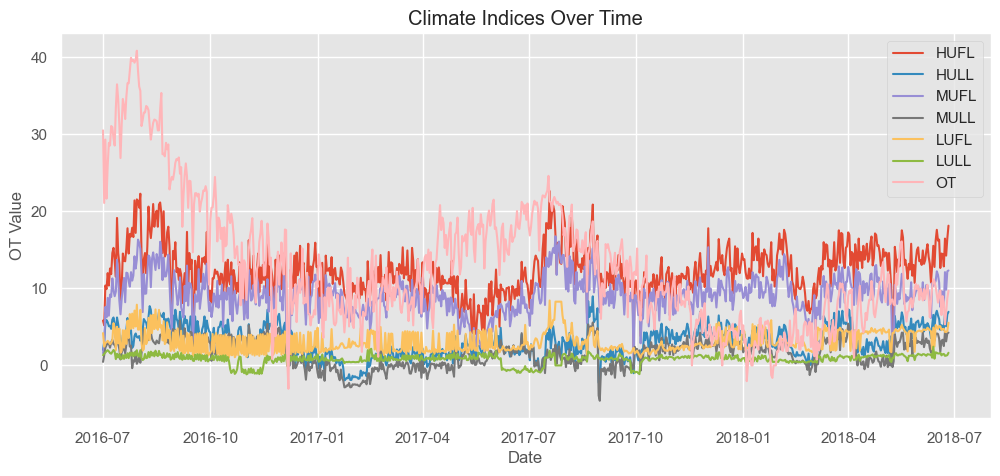

In [51]:

df = pd.read_csv('ETTh1.csv', parse_dates=['date'], dayfirst=False)
df = df.set_index('date').sort_index()

# Ensure we have a consistent frequency (Daily data assumed)
df = df.asfreq('D')  # Daily start frequency
df.interpolate(method='linear', inplace=True)  # If any missing, fill linearly

print("Dataframe head:")
display(df.head())

# Quick plot to see the data
plt.figure(figsize=(12, 5))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.title("Climate Indices Over Time")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()



## Global Train/Test Split

You will split the data into train (80%) and test (20%) sets, focusing on forecasting the **ENSO** column.
Use the other columns (AAO, AO, NAO, PNA, plus ENSO itself if you want to allow the model to see past ENSO) as regressors.



In [52]:
target_col = 'OT'
X = df.copy()  # We'll keep all columns as regressors
y = df[target_col].copy()

# In many cases, you'd drop the target from X, but here let's keep it if we want to allow the model
# to see the "current" (or lagged) ENSO as well. You may find that in a real scenario,
# you'd shift or lag the target to avoid data leakage. For demonstration, let's keep it simple.

train_ratio = 0.8
n = len(df)
split_index = int(n * train_ratio)

train_X = X.iloc[:split_index]
train_y = y.iloc[:split_index]
test_X = X.iloc[split_index:]
test_y = y.iloc[split_index:]

print("Training set size:", len(train_X))
print("Test set size:", len(test_X))


Training set size: 580
Test set size: 146


# SECTION 1: MLP Regression

In this section, you will try:
1. A simple **Multilayer Perceptron (MLP)** Regression, which uses feed-forward neural networks.

You will:
- Fit each model on the training set.
- Obtain **in-sample** fitted values.
- Forecast **out-of-sample** on the test set.
- Plot the entire series, plus the fitted lines (in-sample solid, out-of-sample dashed).
- Add 90% confidence intervals on the out-of-sample portion, using the standard deviation of residuals from the training set.

**MLP Pros**:
- Can model non-linear relationships.
- Flexible architecture (layers, neurons).
**MLP Cons**:
- Prone to overfitting if not tuned carefully.
- Can require more data and compute power.




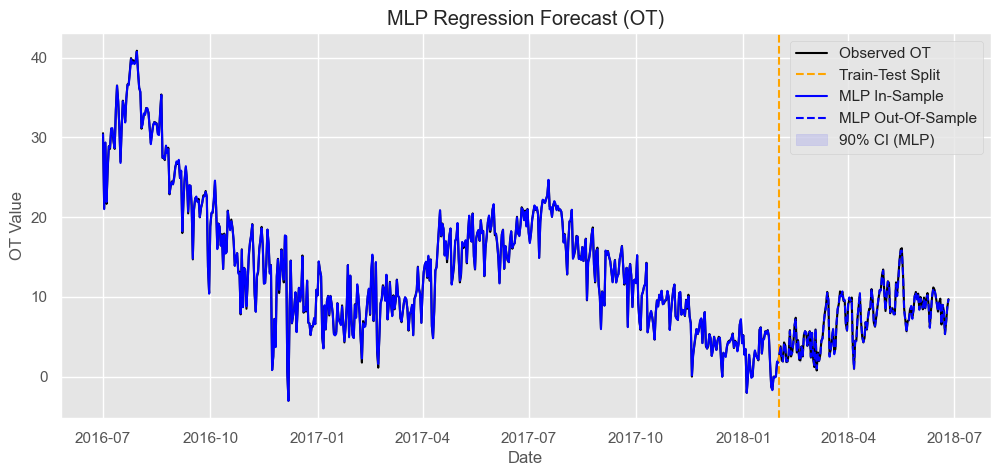

In [53]:
from sklearn.neural_network import MLPRegressor

#---------------------
# 1A. MLP Regressor
#---------------------

mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50),
                         activation='relu',
                         solver='adam',
                         random_state=42,
                         max_iter=2000)

mlp_model.fit(train_X, train_y)

# In-sample fit
mlp_in_sample = mlp_model.predict(train_X)
mlp_residuals = train_y.values - mlp_in_sample

# Out-of-sample
mlp_out_of_sample = mlp_model.predict(test_X)

# CI for out-of-sample
mlp_lower_ci, mlp_upper_ci = bootstrap_confidence_intervals(mlp_out_of_sample, mlp_residuals)

#-----------------------
# Visualization - MLP
#-----------------------
plt.figure(figsize=(12, 5))
plt.plot(y.index, y.values, label='Observed OT', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')

# MLP in-sample
plt.plot(train_y.index, mlp_in_sample, label='MLP In-Sample', color='blue')
# MLP out-of-sample
plt.plot(test_y.index, mlp_out_of_sample, label='MLP Out-Of-Sample', color='blue', linestyle='--')
# MLP CI
plt.fill_between(test_y.index, mlp_lower_ci, mlp_upper_ci, color='blue', alpha=0.1, label='90% CI (MLP)')

plt.title("MLP Regression Forecast (OT)")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()



## SECTION 2: Gradient Boosting Method

**Why Gradient Boosting?**
- Uses an ensemble of weak learners (often decision trees) built sequentially.
- Each new tree attempts to reduce errors left by previous trees.

**Pros**:
- Often yields high accuracy.
- Can handle non-linearities, robust to outliers.

**Cons**:
- Can overfit if not properly tuned (learning rate, number of estimators, depth).
- Training can be slower than simpler models.

**Statistical Insight**:
- Gradient Boosting is essentially an additive model, incrementally improving predictions
  by fitting new models to the current residuals. An internal deviance or MSE-based criterion
  is often used to measure improvement.
- You often see it used in many Kaggle competitions for tabular data due to its high performance.

Let’s fit a simple GradientBoostingRegressor and see how it performs similarly to the steps above:


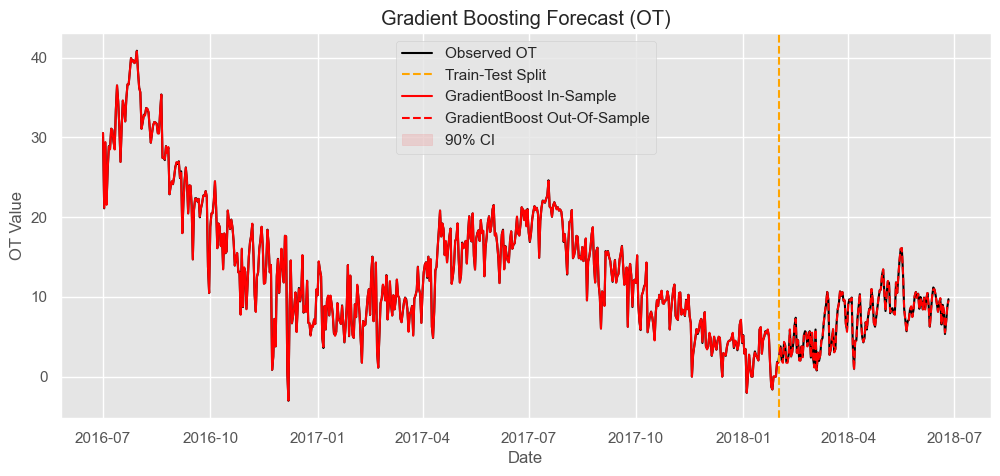

In [54]:
gb_model = GradientBoostingRegressor(n_estimators=100,
                                     learning_rate=0.1,
                                     max_depth=3,
                                     random_state=42)
gb_model.fit(train_X, train_y)

gb_in_sample = gb_model.predict(train_X)
gb_residuals = train_y.values - gb_in_sample
gb_out_of_sample = gb_model.predict(test_X)
gb_lower_ci, gb_upper_ci = bootstrap_confidence_intervals(gb_out_of_sample, gb_residuals)

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(y.index, y.values, label='Observed OT', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')

plt.plot(train_y.index, gb_in_sample, label='GradientBoost In-Sample', color='red')
plt.plot(test_y.index, gb_out_of_sample, label='GradientBoost Out-Of-Sample', color='red', linestyle='--')
plt.fill_between(test_y.index, gb_lower_ci, gb_upper_ci, color='red', alpha=0.1, label='90% CI')

plt.title("Gradient Boosting Forecast (OT)")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()


## SECTION 3: KalmanForecaster

A **Kalman Filter** (or KalmanForecaster in some libraries) is a state-space approach that:
- Models the system as hidden states evolving over time, with observed data providing partial information.
- Iteratively updates its estimates of the hidden states as new observations come in.

**Pros**:
- Handles noisy time series well.
- Great for systems where you believe there's an underlying (hidden) state with linear-Gaussian assumptions.

**Cons**:
- Typically assumes linear-Gaussian state dynamics (though there are non-linear extensions).
- You need to carefully define the state-space structure (trend, seasonal, etc.).

**Practical**:
- In `statsmodels`, you may use `UnobservedComponents` or build a custom state-space model.
- Here, we’ll demonstrate a simple structural time series with a local level or local linear trend,
  then see how well it forecasts ENSO. For a true multivariate approach, you'd incorporate multiple states,
  but let's do a simpler demonstration for clarity.



 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29929D+00    |proj g|=  8.60338D-02

At iterate    5    f=  2.53326D+00    |proj g|=  1.44340D-02

At iterate   10    f=  2.49405D+00    |proj g|=  2.51157D-01

At iterate   15    f=  2.47215D+00    |proj g|=  5.76137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     69      2     0     0   7.989D-05   2.472D+00
  F =   2.4721480109871368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


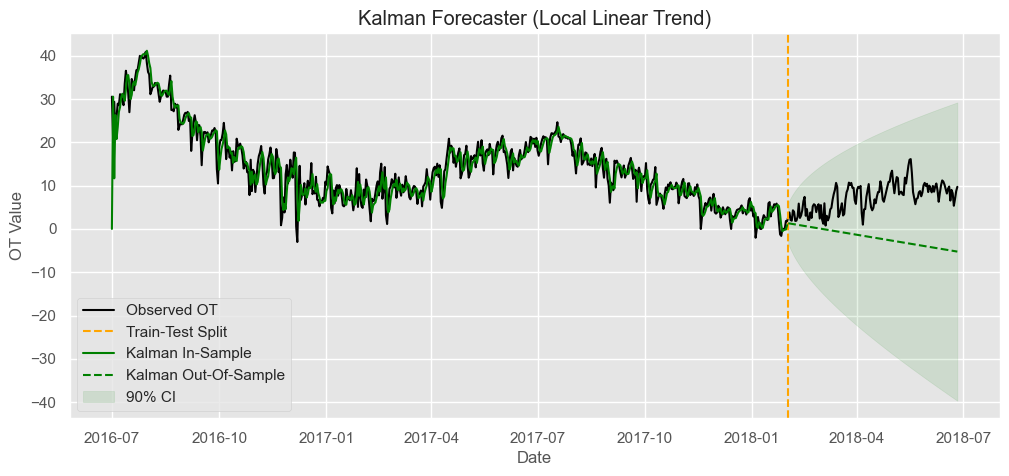

In [55]:
# We'll do a simple approach using UnobservedComponents (only on the target).
# If you want to incorporate the other variables, you'd do a more advanced statespace model.

from statsmodels.tsa.statespace.structural import UnobservedComponents

kalman_model = UnobservedComponents(endog=train_y, level='local linear trend')
kalman_results = kalman_model.fit()

# In-sample
kalman_in_sample = kalman_results.fittedvalues
kalman_residuals = train_y.values - kalman_in_sample.values

# Out-of-sample forecasting
n_test = len(test_y)
kalman_forecast_res = kalman_results.get_forecast(steps=n_test)
kalman_out_of_sample = kalman_forecast_res.predicted_mean
kalman_ci = kalman_forecast_res.conf_int(alpha=0.1)  # 90% CI from the model

# statsmodels directly gives upper and lower CI
kalman_lower_ci = kalman_ci['lower OT']
kalman_upper_ci = kalman_ci['upper OT']

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(y.index, y.values, label='Observed OT', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')

plt.plot(train_y.index, kalman_in_sample, label='Kalman In-Sample', color='green')
plt.plot(test_y.index, kalman_out_of_sample, label='Kalman Out-Of-Sample', color='green', linestyle='--')
plt.fill_between(test_y.index, kalman_lower_ci, kalman_upper_ci, color='green', alpha=0.1, label='90% CI')

plt.title("Kalman Forecaster (Local Linear Trend)")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()



# ## SECTION 4: LSTM
#
# **Why LSTM?**
# - LSTM (Long Short-Term Memory) networks handle long-range dependencies by using gated structures.
# - Often used for complex sequence data (NLP, time series).
#
# **Pros**:
# - Learns temporal relationships well.
# - Can capture non-linearities and memory better than simple feed-forward.
#
# **Cons**:
# - Requires more data, more compute.
# - Hyperparameter tuning can be extensive.
#
# **Practical Approach**:
# - You may find it beneficial to scale your data before feeding into LSTM.
# - You also typically need to create sequences of data of some fixed length (seq_length).
# - We’ll keep it minimal here to illustrate how you might do a multivariate approach
#   that predicts the **next** value of **all features** (or you can pick just ENSO).
#
# Below, you will see simplified code that uses the helper functions you provided:
# - `create_sequences_multivariate(data, seq_length)`
# - `build_optimized_lstm_model(sequence_length, num_features, ...)`
#
# You need to remember that for a real application, you should do more thorough tuning, e.g., epochs, batch_size, additional callbacks, etc.



/Users/ycy/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


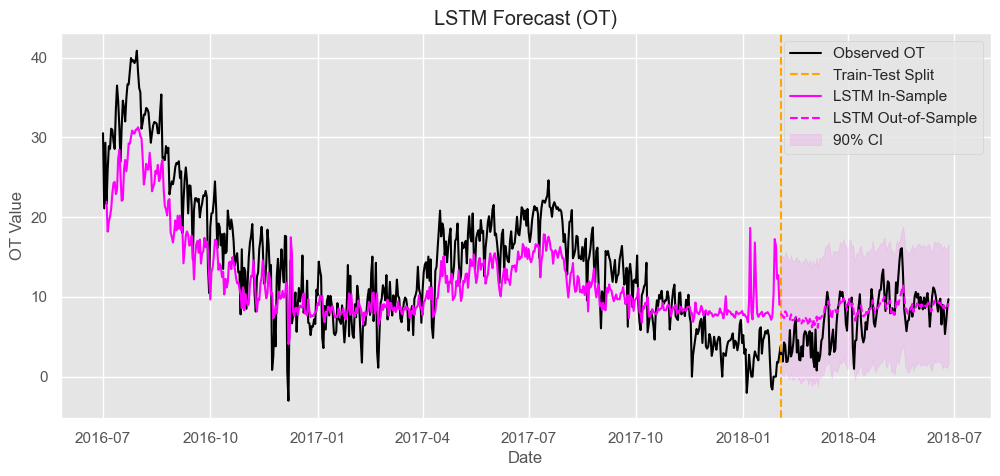

In [56]:
from sklearn.preprocessing import MinMaxScaler
# We'll define the two helper functions from the instructions in a simpler form:

def create_sequences_multivariate(data, seq_length):
    """
    Create sequences from multivariate data for predicting all variables at the next time step.
    data: Numpy array of shape (n_samples, n_features)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])  # sequence_length steps
        y.append(data[i + seq_length, :])  # next time step
    return np.array(X), np.array(y)


def build_optimized_lstm_model(sequence_length, num_features, units=50, dropout_rate=0.2):
    """
    Build a minimal LSTM model.
    We won't do multiple layers or complex hyperparams for brevity.
    """
    model = models.Sequential()
    model.add(layers.LSTM(units=units, input_shape=(sequence_length, num_features),
                          return_sequences=False, dropout=dropout_rate))
    model.add(layers.Dense(num_features))  # predict all features
    model.compile(loss='mse', optimizer='adam')
    return model


# Prepare data for LSTM
# We'll transform the entire dataset (all columns) into a numpy array
data_values = df.values
num_features = data_values.shape[1]

# Let's choose a sequence length
seq_length = 3

# Create sequences
X_seq, y_seq = create_sequences_multivariate(data_values, seq_length)

# For demonstration, let's do a simple train/test split on these sequences
# Because we lose (seq_length) steps, the final length of X_seq is len(df)-seq_length
split_index_lstm = int(0.8 * len(X_seq))
X_train_seq = X_seq[:split_index_lstm]
y_train_seq = y_seq[:split_index_lstm]
X_test_seq = X_seq[split_index_lstm:]
y_test_seq = y_seq[split_index_lstm:]

# Build the model
lstm_model = build_optimized_lstm_model(sequence_length=seq_length, num_features=num_features,
                                        units=32, dropout_rate=0.2)

# Fit
history = lstm_model.fit(X_train_seq, y_train_seq,
                         validation_split=0.1,
                         epochs=100,
                         batch_size=16,
                         verbose=0)

# In-sample predictions (on training portion)
lstm_in_sample_preds = lstm_model.predict(X_train_seq)
# Out-of-sample predictions
lstm_out_of_sample_preds = lstm_model.predict(X_test_seq)

# We want to compare just the ENSO dimension from these predictions
enso_index = df.columns.get_loc('OT')
lstm_in_sample_enso = lstm_in_sample_preds[:, enso_index]
lstm_out_sample_enso = lstm_out_of_sample_preds[:, enso_index]

# The "true" values for training/test in terms of ENSO
enso_train_true = y_train_seq[:, enso_index]
enso_test_true = y_test_seq[:, enso_index]

# Residuals from training
lstm_residuals = enso_train_true - lstm_in_sample_enso
lstm_lower_ci, lstm_upper_ci = bootstrap_confidence_intervals(lstm_out_sample_enso, lstm_residuals)

# We also need a timeline for in-sample and out-of-sample in the LSTM approach
# The earliest date we can map is date index = seq_length
dates_array = df.index[seq_length:]  # X_seq, y_seq are aligned to start from seq_length

train_dates = dates_array[:split_index_lstm]
test_dates = dates_array[split_index_lstm:]

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['OT'].values, label='Observed OT', color='black')
plt.axvline(x=test_dates[0], color='orange', linestyle='--', label='Train-Test Split')

plt.plot(train_dates, lstm_in_sample_enso, label='LSTM In-Sample', color='magenta')
plt.plot(test_dates, lstm_out_sample_enso, label='LSTM Out-of-Sample', color='magenta', linestyle='--')
plt.fill_between(test_dates, lstm_lower_ci, lstm_upper_ci, color='magenta', alpha=0.1, label='90% CI')

plt.title("LSTM Forecast (OT)")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()



## SECTION 6: Accuracy Comparison (Simple vs. Rolling)

You have now a variety of models:
- MLP
- GradientBoost
- Kalman
- LSTM

**Simple Out-of-Sample Forecast** means you train once on the training set, then predict the entire test set.
**Rolling Forecast** means you move step by step, refitting (or partially updating) as each new data point arrives.

### 6.1 Simple Out-of-Sample
You already have the predictions for MLP, GB, Kalman in the same time scale. LSTM is a bit different because it used sequences.
For demonstration, let's just compute metrics for MLP, GB, and Kalman directly on the aligned time index of **test_y**.

For LSTM, we can do a partial alignment: the test portion for LSTM starts at `test_dates[0]`. So let's also compare them carefully.



In [ ]:

# Collect predictions from MLP, GB, Kalman to match test_y
# test_y is from index=split_index: to the end

# 1. MLP
mlp_pred_test = pd.Series(mlp_out_of_sample, index=test_y.index)

# 2. Gradient Boost
gb_pred_test = pd.Series(gb_out_of_sample, index=test_y.index)

# 3. Kalman
kalman_pred_test = kalman_out_of_sample
kalman_pred_test.index = test_y.index  # to align with test_y

# Evaluate each (train_y is used for MASE)
mlp_metrics_simple = compute_metrics(test_y.values, mlp_pred_test.values, train_y.values)
gb_metrics_simple = compute_metrics(test_y.values, gb_pred_test.values, train_y.values)
kalman_metrics_simple = compute_metrics(test_y.values, kalman_pred_test.values, train_y.values)

# For LSTM, we have a separate test set (enso_test_true) on test_dates
# We need to align it with test_y. The simplest approach is to compute metrics on that portion alone.
# We'll do direct:
lstm_metrics_simple = compute_metrics(enso_test_true, lstm_out_sample_enso, enso_train_true)

# Print as DataFrame
methods_simple = {
    'MLP': mlp_metrics_simple,
    'GradientBoost': gb_metrics_simple,
    'Kalman': kalman_metrics_simple,
    'LSTM': lstm_metrics_simple
}

df_simple_metrics = pd.DataFrame(methods_simple).T
df_simple_metrics


,max_error,MAE,MSE,RMSE,MAPE,MASE
MLP,0.383629,0.103343,0.018463,0.135880,1.929249,0.048015
GradientBoost,0.233683,0.061597,0.006119,0.078222,1.296185,0.028619
Kalman,19.544506,9.273856,107.928023,10.388841,121.961652,4.308762
LSTM,6.864547,2.106423,7.596138,2.756109,61.702971,0.994722


In [60]:
print(df_simple_metrics)

               max_error       MAE         MSE       RMSE        MAPE  \
MLP             0.383629  0.103343    0.018463   0.135880    1.929249   
GradientBoost   0.233683  0.061597    0.006119   0.078222    1.296185   
Kalman         19.544506  9.273856  107.928023  10.388841  121.961652   
LSTM            6.864547  2.106423    7.596138   2.756109   61.702971   

                   MASE  
MLP            0.048015  
GradientBoost  0.028619  
Kalman         4.308762  
LSTM           0.994722  


### 6.2 Rolling Forecast

You may find it instructive to do a rolling forecast approach for MLP, Gradient Boost, and see how it performs.
Kalman can be updated incrementally, and LSTM also can be updated, but let's keep it simpler here.

We'll do a short demonstration for rolling MLP. For GradientBoost, the same approach applies (though it can be slower).



In [59]:
def mlp_constructor():
    return MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)

def gb_constructor():
    return GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


# Rolling
mlp_rolling = rolling_forecast(mlp_constructor, train_X, train_y, test_X, test_y)
gb_rolling = rolling_forecast(gb_constructor, train_X, train_y, test_X, test_y)

mlp_rolling_metrics = compute_metrics(test_y.values, mlp_rolling, train_y.values)
gb_rolling_metrics = compute_metrics(test_y.values, gb_rolling, train_y.values)

# We won't do Kalman or LSTM rolling here for brevity.
rolling_methods = {
    'MLP': mlp_rolling_metrics,
    'GradientBoost': gb_rolling_metrics
}

df_rolling_metrics = pd.DataFrame(rolling_methods).T
df_rolling_metrics


,max_error,MAE,MSE,RMSE,MAPE,MASE
MLP,0.335375,0.079684,0.010870,0.104259,1.468502,0.037022
GradientBoost,0.208226,0.048250,0.004081,0.063880,1.066578,0.022417


In [61]:
print(df_rolling_metrics)

               max_error       MAE       MSE      RMSE      MAPE      MASE
MLP             0.335375  0.079684  0.010870  0.104259  1.468502  0.037022
GradientBoost   0.208226  0.048250  0.004081  0.063880  1.066578  0.022417


# Discussion & Wrap-up

In this lecture, you learned how to apply several advanced methods to a multivariate time series (forecasting ENSO using AAO, AO, NAO, PNA, and ENSO itself):
1. **MLP Regression** with a feed-forward network.
2. **Gradient Boosting** regression.
3. A **Kalman-based** approach (local linear trend).
4. **LSTM** for sequential modeling.

You also compared their simple out-of-sample forecasts and (for some models) rolling forecasts using accuracy metrics like max_error, MAE, MSE, RMSE, MAPE, and MASE.

## Key Insights:
- **MLP** and **LSTM** can capture non-linear relationships but require more data and careful hyperparameter tuning.
- **Gradient Boosting** is often a strong baseline for tabular data, but watch out for overfitting and training time.
- **Kalman** approaches are powerful for state-space modeling; they’re great when you believe there is an underlying state with linear-Gaussian transitions.

## Pros & Cons Recap:
**MLP**:
- Pros: flexible, non-linear, relatively straightforward to implement.
- Cons: can overfit, might be slow if network is large, careful with scaling.

**Gradient Boosting**:
- Pros: strong performance, interpretable feature importances, wide adoption.
- Cons: many hyperparameters, can overfit, somewhat slow if the dataset is large.

**Kalman**:
- Pros: interpretable state-space representation, handles noise well.
- Cons: requires correct assumptions about state transitions, linear-Gaussian limitations (for basic version).

**LSTM**:
- Pros: powerful for sequence data and memory, captures non-linearities.
- Cons: can require a lot of data and compute, tricky to tune, easily overfit.

## Final Takeaways
You need to remember to:
1. Consider the nature of your data (stationarity, noise level, underlying processes).
2. Try simpler models first, then move to more complex ones as needed.
3. Perform thorough hyperparameter tuning and cross-validation if possible.
4. Evaluate both **simple out-of-sample** and **rolling** forecasts to get a more realistic understanding of performance.

You should now have a broader view of how to implement and compare these advanced forecasting methods for multivariate time series.
Feel free to extend these examples with more rigorous feature engineering, hyperparameter searches, and advanced interpretability tools.

**End of Lecture 5.**

---
### Next Steps:
- Explore more advanced or specialized neural networks (e.g., 1D CNN, Transformers).
- Dive deeper into state-space models with more complex structures.
- Investigate robust scaling or normalizing your data, especially for KNN, MLP, LSTM.
- Use cross-validation or Bayesian optimization to systematically tune hyperparameters.
- Incorporate domain knowledge: If you know certain lags or seasonality matter, explicitly model them or create engineered features for them.

**Congratulations on finishing TSF Lecture 5!**

---


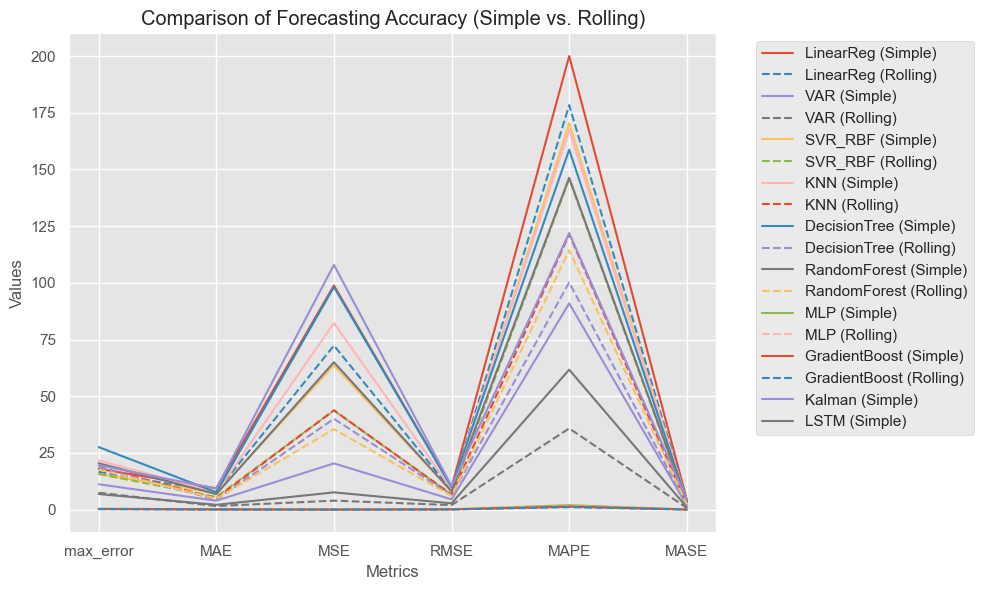

In [ ]:
import matplotlib.pyplot as plt

# 需要绘制的指标（顺序将作为 x 轴刻度）
metrics = ["max_error", "MAE", "MSE", "RMSE", "MAPE", "MASE"]

# 将每个方法的 simple 和 rolling 数据存放在一个字典中
# 若某方法没有 rolling 数据，则 rolling 部分可以设置为 None 或直接省略
data = {
    "LinearReg": {
        "simple": [17.935899, 9.392129,  98.84034,  9.941848, 200.043562,  4.363714],
        "rolling": [16.636338, 7.826856, 72.357478, 8.50632,  178.38491,   3.636466],
    },
    "VAR": {
        "simple": [11.15923, 3.907238, 20.359628, 4.512164, 90.957057, 1.815357],
        "rolling": [7.433545, 1.556315, 3.937513, 1.984317, 35.800529, 0.723085],
    },
    "SVR_RBF": {
        "simple": [15.693519, 7.257191, 63.639642, 7.977446, 170.444719, 3.371792],
        "rolling": [15.693519, 5.552888, 43.700182, 6.610611, 145.856738, 2.579949],
    },
    "KNN": {
        "simple": [21.736999, 7.532729, 82.252800, 9.069333, 167.405756, 3.499811],
        "rolling": [18.712800, 4.964751, 43.780243, 6.616664, 121.417701, 2.306692],
    },
    "DecisionTree": {
        "simple": [27.562600, 7.629228, 98.151569, 9.907147, 158.718049, 3.544646],
        "rolling": [18.558750, 4.381771, 40.022677, 6.326348, 100.195387, 2.035832],
    },
    "RandomForest": {
        "simple": [20.440523, 6.827421, 64.995221, 8.061961, 146.338382, 3.172115],
        "rolling": [17.681690, 4.858292, 35.476737, 5.956235, 114.317367, 2.257230],
    },
    "MLP": {
        # 第一行是“simple”，第二行是“rolling”；若只有一行，就仅有 simple
        "simple": [0.383629, 0.103343, 0.018463, 0.135880, 1.929249, 0.048015],
        "rolling": [0.335375, 0.079684, 0.010870, 0.104259, 1.468502, 0.037022],
    },
    "GradientBoost": {
        "simple": [0.233683, 0.061597, 0.006119, 0.078222, 1.296185, 0.028619],
        "rolling": [0.208226, 0.048250, 0.004081, 0.063880, 1.066578, 0.022417],
    },
    "Kalman": {
        "simple": [19.544506, 9.273856, 107.928023, 10.388841, 121.961652, 4.308762],
        # 没有 rolling 数据
    },
    "LSTM": {
        "simple": [6.864547, 2.106423, 7.596138, 2.756109, 61.702971, 0.994722],
        # 没有 rolling 数据
    }
}

plt.figure(figsize=(10, 6))  # 可根据需要调整画布尺寸

# 让 matplotlib 使用默认的颜色循环，不同方法会自动分配不同颜色
for method_idx, (method_name, method_data) in enumerate(data.items()):
    # 如果有 simple 数据，就画实线
    if "simple" in method_data and method_data["simple"] is not None:
        plt.plot(metrics,
                 method_data["simple"],
                 label=f"{method_name} (Simple)",
                 linestyle='solid')  # 实线

    # 如果有 rolling 数据，就画虚线
    if "rolling" in method_data and method_data["rolling"] is not None:
        plt.plot(metrics,
                 method_data["rolling"],
                 label=f"{method_name} (Rolling)",
                 linestyle='dashed')  # 虚线

plt.title("Comparison of Forecasting Accuracy (Simple vs. Rolling)")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例放在右侧，防止遮挡
plt.tight_layout()
plt.show()
